In [92]:
# Module Imported 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import pandas as pd
from pathlib import Path

# ===== 1) 读取数据 =====
DATA_PATH = "dataSet/heart.csv"   # 改成你的文件名
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
print(df.info())
print("-----------------------------")
print(df.isna().sum())
print(df['ST_Slope'].head())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
-----------------------------
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
Exercis

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [70]:
import pandas as pd
from pathlib import Path

# ===== 1) 读取数据 =====
DATA_PATH = "dataSet/heart.csv"   # 改成你的文件名
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# ===== 2) 基本检查 =====
expected = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS',
            'RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"missing column: {missing}")

y = df['HeartDisease'].astype(int) #

X = df.drop(columns=['HeartDisease']).copy()

# Turn string categorical value into value 
# Sex, ChestPain(0-3)(ATA, NAP, ASY, TA), RestingECG (0-2)(Normal, ST, LVH), ExerciseAngina (0-1)(Yes, NO), ST_Slope(0-2)(Up, Flat, Down)

# Sex: M/F -> 1/0
X['Sex'] = X['Sex'].str.strip().map({'M': 1, 'F': 0}).astype(int)

# ExerciseAngina: Y/N -> 1/0
X['ExerciseAngina'] = X['ExerciseAngina'].str.strip().map({'Y': 1, 'N': 0}).astype(int)

# chestpaintype
chestPainType = {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
X['ChestPainType'] = X['ChestPainType'].str.strip().map(chestPainType).astype(int)

# restingECG
restingECGType = {"Normal": 0, 'ST': 1, 'LVH': 2}
X['RestingECG'] = X['RestingECG'].str.strip().map(restingECGType).astype(int)

# st slope
slope = {'Up': 0, 'Flat': 1, 'Down': 2}
X['ST_Slope'] = X['ST_Slope'].str.strip().map(slope).astype(int)

# FastingBS make sure it is type int.
X['FastingBS'] = X['FastingBS'].astype(int)



# ===== 7) 输出保存 =====
out_dir = Path("processed")
out_dir.mkdir(exist_ok=True)

X_path = out_dir / "X_encoded.csv"
y_path = out_dir / "y.csv"
cols_path = out_dir / "feature_names.txt"

X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False, header=['HeartDisease'])

with open(cols_path, "w", encoding="utf-8") as f:
    for c in X.columns:
        f.write(c + "\n")

print("✅ 数据清洗与编码完成")
print(f"X_encoded 形状: {X.shape} -> {X_path}")
print(f"y 形状        : {y.shape} -> {y_path}")
print("特征列已保存到:", cols_path)



✅ 数据清洗与编码完成
X_encoded 形状: (918, 11) -> processed\X_encoded.csv
y 形状        : (918,) -> processed\y.csv
特征列已保存到: processed\feature_names.txt


In [102]:
# Split Dataset 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# rf_model = RandomForestClassifier(
#     n_estimators=500,
#     criterion='entropy',
#     max_depth=None,
#     class_weight='balanced_subsample',
#     random_state=42,
#     n_jobs=-1
# )

model = XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    eval_metric="logloss",      # 防止报warning
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [103]:
# stage 2, using Chi-square and and PCA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

num_cols = [
    "Age", "RestingBP", "Cholesterol", "FastingBS",
    "MaxHR", "Oldpeak"
]

cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)
chi2_selector = Pipeline([
    ("scale_for_chi2", MinMaxScaler()),
    ("chi2", SelectKBest(score_func=chi2, k=9))
])

pca_reduce = PCA(n_components=6, random_state=42)

clf = Pipeline([
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("pca", pca_reduce),
    ("model", svmodel)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.2, random_state=42, shuffle=True, stratify=y
)
clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('chi2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Eigenvalues for each component:
Component 1: 12007.262
Component 2: 641.076
Component 3: 327.276
Component 4: 69.592
Component 5: 1.282
Component 6: 0.623
Component 7: 0.532
Component 8: 0.233
Component 9: 0.167
Component 10: 0.159
Component 11: 0.134

✅ Number of components with eigenvalue > 1.0 : 5


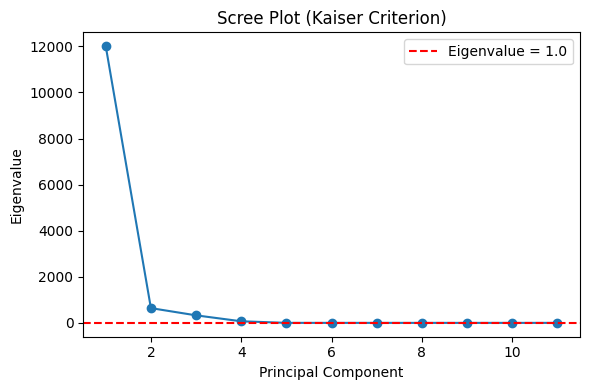

In [73]:
# Keep all component that has eigenvalues > 1
pca = PCA()
pca.fit(X)

eigenvalues = pca.explained_variance_

print("Eigenvalues for each component:")
for i, val in enumerate(eigenvalues, 1):
    print(f"Component {i}: {val:.3f}")

# 统计 eigenvalue > 1 的数量
n_above_one = np.sum(eigenvalues > 1)
print(f"\n✅ Number of components with eigenvalue > 1.0 : {n_above_one}")

# 画图展示
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1.0')
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot (Kaiser Criterion)")
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
param_grid = {
    "chi2__chi2__k" : [9,10, 11],
    "pca__n_components":[1,2,3,4,5,6,7,8],
    # "model__n_estimators":[100,200,300]
}
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs= -1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'chi2__chi2__k': 9, 'pca__n_components': 5}
Best Accuracy: 0.8637126083310036


In [96]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8586956521739131
ROC-AUC: 0.8653156384505022

Confusion Matrix: 
 [[67 15]
 [11 91]]
